In [6]:
Train_Raw = pd.read_parquet("Train.parquet")

In [9]:
Train_Raw.head(1).transpose()

,0
S0_0,211.352480
S0_1,153.859221
S0_2,227.924505
sigma_0,0.156019
sigma_1,0.155995
sigma_2,0.058084
delta_0,14.459270
delta_1,-21.049263
delta_2,-17.902740
delta_se_0,10.070562


In [10]:
import re, pandas as pd, pathlib

DROP_PATTERNS = [
    r"^delta_", r"^gamma_", r"^vega_", r"^rho", r"^theta",  # every Greek
    r"_se$"                                                  # any “…_se” column
]

def clean_parquet(src_path, dst_path=None):
    """
    Load a Parquet file, drop all columns matching DROP_PATTERNS,
    write out a new '_clean.parquet', and return the new path.
    """
    src = pathlib.Path(src_path)
    df  = pd.read_parquet(src, engine="pyarrow")  # now that pyarrow is installed

    keep_cols = [c for c in df.columns
                 if not any(re.search(p, c) for p in DROP_PATTERNS)]

    if dst_path is None:
        dst = src.with_stem(src.stem + "_clean")  # e.g. Train_clean.parquet
    else:
        dst = pathlib.Path(dst_path)

    df[keep_cols].to_parquet(dst, index=False)
    print(f"✓ {src.name:15s} → {dst.name:17s}   kept {len(keep_cols)}/{df.shape[1]} columns")
    return dst

# Run on your actual files:
TRAIN_CLEAN = clean_parquet("Train.parquet")        # writes Train_clean.parquet
TEST_CLEAN  = clean_parquet("Test100M.parquet")     # writes Test100M_clean.parquet


✓ Train.parquet   → Train_clean.parquet   kept 9/32 columns
✓ Test100M.parquet → Test100M_clean.parquet   kept 9/32 columns


# Neural Net

In [1]:
# Cell 1 — imports & device setup
import os, math, random, time, pathlib, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics import R2Score

# Use inline plots
%matplotlib inline

os.environ.setdefault("NCCL_P2P_LEVEL", "0")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Running on: cuda


In [2]:
# Cell 2 — load & split cleaned Parquet into train/val/test TensorDatasets

# 1) Read cleaned Parquet files
#    (assumes you have already run clean_parquet on Train.parquet and Test100M.parquet)
train_df = pd.read_parquet("Train_clean.parquet", engine="pyarrow")
test_df  = pd.read_parquet("Test100M_clean.parquet", engine="pyarrow")

# 2) Split train_df → 80% train, 20% validation
X_full = train_df.drop(columns=["price"]).values.astype(np.float32)
y_full = train_df["price"].values.astype(np.float32)
X_tr_np, X_val_np, y_tr_np, y_val_np = train_test_split(
    X_full, y_full, test_size=0.01, random_state=42
)

# 3) Build TensorDatasets
train_ds = TensorDataset(torch.from_numpy(X_tr_np), torch.from_numpy(y_tr_np))
val_ds   = TensorDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np))
test_ds  = TensorDataset(
    torch.from_numpy(test_df.drop(columns=["price"]).values.astype(np.float32)),
    torch.from_numpy(test_df["price"].values.astype(np.float32))
)

print(f"train {len(train_ds):,} rows")
print(f"valid {len(val_ds):,} rows")
print(f" test {len(test_ds):,} rows")


train 4,950,000 rows
valid 50,000 rows
 test 500 rows


In [3]:
# Cell 3 — define the MLP (BasketNet) model

class BasketNet(nn.Module):
    def __init__(self, in_dim: int, width: int, layers: int):
        """
        in_dim = number of input features
        width  = nodes per hidden layer
        layers = number of hidden layers
        """
        super().__init__()
        blocks = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(layers - 1):
            blocks += [nn.Linear(width, width), nn.ReLU()]
        blocks.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*blocks)

        # Xavier initialization
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        return self.net(x)


In [4]:
def run_experiment_updates_per_update(
    width: int = 300,
    layers: int = 4,
    batch_size: int = 50_000,
    n_updates: int = 100_000,     # total mini‐batch updates
    lr: float = 1e-3,
    optimizer_name: str = "Adam",
    seed: int = 42,
    save_model: bool = False      # ← new flag
):
    """
    Train for exactly n_updates mini‐batches, recording
    train/val MSE at each update, then evaluate on test set.

    Args:
      width, layers:    model architecture
      batch_size:       mini‐batch size
      n_updates:        total optimizer steps (updates)
      lr:               learning rate
      optimizer_name:   "Adam" | "SGD" | "LBFGS"
      seed:             random seed
      save_model:       if True, save final weights to disk
    """
    # 5.1) Re‐seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # 5.2) Build DataLoaders
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, pin_memory=True
    )

    # 5.3) Instantiate the model
    in_dim = train_ds[0][0].shape[0]
    model = BasketNet(in_dim, width, layers).to(DEVICE)
    if DEVICE.type == "cuda" and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    # 5.4) Loss & optimizer
    criterion = nn.MSELoss()
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == "LBFGS":
        optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=20)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # 5.5) Create an infinite iterator over shuffled train_loader
    def infinite_train_iter(loader):
        while True:
            for batch in loader:
                yield batch

    inf_train = infinite_train_iter(train_loader)

    # 5.6) Storage for train/val losses (one entry per update)
    train_losses = []  # len == n_updates, MSE on that mini‐batch
    valid_losses = []  # len == n_updates, MSE on full validation set

    # 5.7) Main loop: exactly n_updates optimizer steps
    model.train()
    for step in range(1, n_updates + 1):
        # ----- fetch one mini‐batch (reshuffled as needed)
        Xb, yb = next(inf_train)
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE).unsqueeze(1)

        # ----- forward/backward / optimizer step
        if optimizer_name == "LBFGS":
            def closure():
                optimizer.zero_grad(set_to_none=True)
                out  = model(Xb)
                loss = criterion(out, yb)
                loss.backward()
                return loss
            optimizer.step(closure)
            loss_train = closure().item()
        else:
            optimizer.zero_grad(set_to_none=True)
            out        = model(Xb)
            loss       = criterion(out, yb)
            loss.backward()
            optimizer.step()
            loss_train = loss.item()

        train_losses.append(loss_train)

        # ----- validation MSE after this update
        model.eval()
        tot_val, cnt_val = 0.0, 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(DEVICE), yv.to(DEVICE).unsqueeze(1)
                ov = model(Xv)
                tot_val += criterion(ov, yv).item() * Xv.size(0)
                cnt_val += Xv.size(0)
        val_mse = tot_val / cnt_val
        valid_losses.append(val_mse)
        model.train()

        # ----- Logging
        if step == 1 or step == n_updates or step % max(1, n_updates // 10) == 0:
            print(f"[update {step}/{n_updates}] "
                  f"train MSE={loss_train:.3e}  val MSE={val_mse:.3e}")

    # 5.8) Plot log₁₀ of cumulative-min train/valid MSE vs. update index
    train_min = np.minimum.accumulate(train_losses)
    valid_min = np.minimum.accumulate(valid_losses)

    plt.figure(figsize=(7, 4))
    plt.plot(np.log10(train_min), label="train (cum-min)")
    plt.plot(np.log10(valid_min), label="valid (cum-min)")
    plt.xlabel("update index")
    plt.ylabel("log10 MSE")
    plt.title(f"{layers}×{width} • bs={batch_size} • {optimizer_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5.9) Final test‐set evaluation
    model.eval()
    all_preds, all_truths = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            pr = model(Xb.to(DEVICE)).cpu().squeeze()
            all_preds.append(pr)
            all_truths.append(yb)
    preds  = torch.cat(all_preds)
    truths = torch.cat(all_truths)
    test_mse = criterion(preds.unsqueeze(1), truths.unsqueeze(1)).item()
    test_r2  = R2Score()(preds, truths).cpu().item()
    print(f"\nTest results → MSE = {test_mse:.3e}   R² = {test_r2:.4f}")

    # 5.10) Optionally save model weights (only if save_model=True)
    if save_model:
        tag = f"w{width}_L{layers}_bs{batch_size}_upd{n_updates}_" \
              f"{optimizer_name}_lr{lr:g}"
        torch.save(model.state_dict(), f"model_{tag}.pt")
        print(f"Saved model to model_{tag}.pt")


# Testing Model

# 3x4

## 5k

[update 1/1000] train MSE=6.544e+02  val MSE=1.481e+03
[update 100/1000] train MSE=2.181e+02  val MSE=2.288e+02
[update 200/1000] train MSE=1.581e+02  val MSE=1.449e+02
[update 300/1000] train MSE=1.128e+02  val MSE=1.153e+02
[update 400/1000] train MSE=1.311e+02  val MSE=1.291e+02
[update 500/1000] train MSE=9.735e+01  val MSE=1.521e+02
[update 600/1000] train MSE=9.496e+01  val MSE=9.053e+01
[update 700/1000] train MSE=8.926e+01  val MSE=8.785e+01
[update 800/1000] train MSE=8.674e+01  val MSE=8.373e+01
[update 900/1000] train MSE=8.417e+01  val MSE=8.030e+01
[update 1000/1000] train MSE=7.542e+01  val MSE=7.939e+01


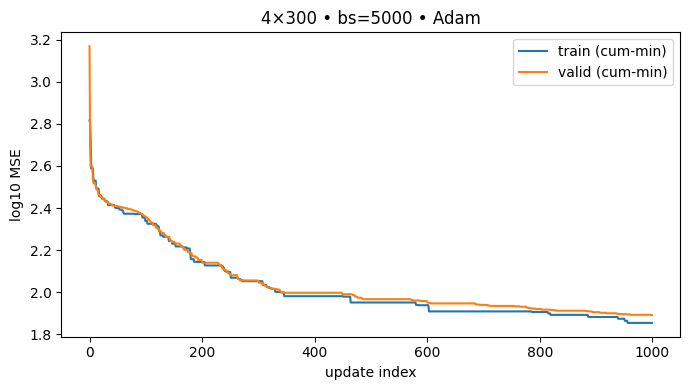


Test results → MSE = 7.810e+01   R² = 0.8731


In [5]:
WIDTH      = 300        # number of neurons per hidden layer
LAYERS     = 4          # number of hidden layers
BATCH_SIZE = 5000     # mini‐batch size
N_UPDATES  = 1000    # total optimizer steps (mini‐batches)
LR         = 1e-3       # learning rate
OPTIMIZER  = "Adam"     # choices: "Adam", "SGD", or "LBFGS"
SEED       = 42         # random seed

run_experiment_updates_per_update(
        width=WIDTH,
        layers=LAYERS,
        batch_size=BATCH_SIZE,
        n_updates=N_UPDATES,
        lr=LR,
        optimizer_name=OPTIMIZER,
        seed=SEED,
        save_model=False  # set to True to save model weights
    )

[update 1/10000] train MSE=6.544e+02  val MSE=1.481e+03
[update 1000/10000] train MSE=7.542e+01  val MSE=7.939e+01
[update 2000/10000] train MSE=6.732e+01  val MSE=6.522e+01
[update 3000/10000] train MSE=5.761e+01  val MSE=5.919e+01
[update 4000/10000] train MSE=4.721e+01  val MSE=5.056e+01
[update 5000/10000] train MSE=4.641e+01  val MSE=4.071e+01
[update 6000/10000] train MSE=3.737e+01  val MSE=3.755e+01
[update 7000/10000] train MSE=3.727e+01  val MSE=3.618e+01
[update 8000/10000] train MSE=3.342e+01  val MSE=3.518e+01
[update 9000/10000] train MSE=3.302e+01  val MSE=3.419e+01
[update 10000/10000] train MSE=3.429e+01  val MSE=3.389e+01


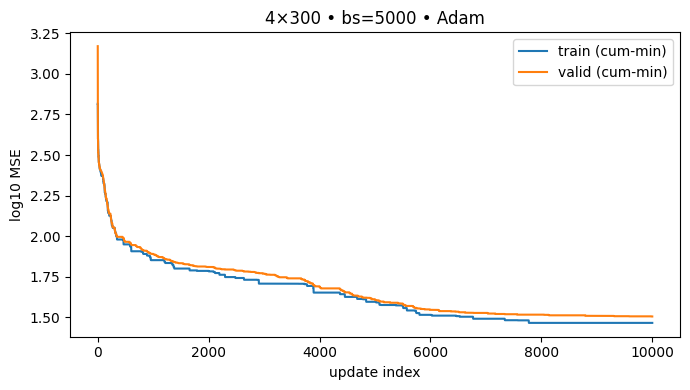


Test results → MSE = 3.253e+01   R² = 0.9472


In [17]:
WIDTH      = 300        # number of neurons per hidden layer
LAYERS     = 4          # number of hidden layers
BATCH_SIZE = 5000     # mini‐batch size
N_UPDATES  = 10000    # total optimizer steps (mini‐batches)
LR         = 1e-3       # learning rate
OPTIMIZER  = "Adam"     # choices: "Adam", "SGD", or "LBFGS"
SEED       = 42         # random seed

run_experiment_updates_per_update(
        width=WIDTH,
        layers=LAYERS,
        batch_size=BATCH_SIZE,
        n_updates=N_UPDATES,
        lr=LR,
        optimizer_name=OPTIMIZER,
        seed=SEED,
        save_model=False  # set to True to save model weights
    )

## 10k

[update 1/500] train MSE=6.415e+02  val MSE=1.485e+03
[update 50/500] train MSE=2.495e+02  val MSE=2.538e+02
[update 100/500] train MSE=2.189e+02  val MSE=2.200e+02
[update 150/500] train MSE=1.724e+02  val MSE=2.240e+02
[update 200/500] train MSE=1.437e+02  val MSE=1.403e+02
[update 250/500] train MSE=1.383e+02  val MSE=1.317e+02
[update 300/500] train MSE=1.510e+02  val MSE=1.331e+02
[update 350/500] train MSE=1.225e+02  val MSE=1.089e+02
[update 400/500] train MSE=1.208e+02  val MSE=1.232e+02
[update 450/500] train MSE=1.192e+02  val MSE=1.189e+02
[update 500/500] train MSE=1.290e+02  val MSE=1.386e+02


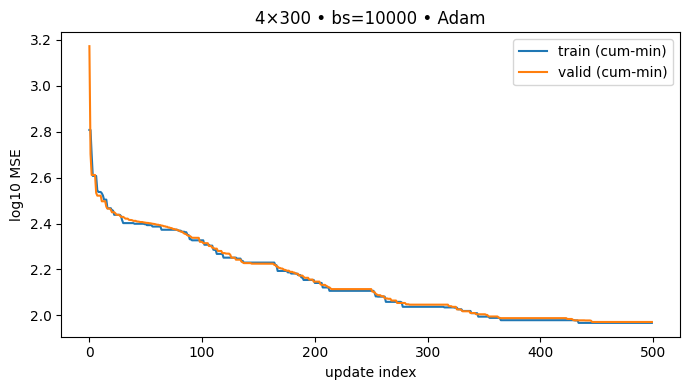


Test results → MSE = 1.561e+02   R² = 0.7464


In [6]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=10000,
        n_updates=500,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/5000] train MSE=6.415e+02  val MSE=1.485e+03
[update 500/5000] train MSE=1.290e+02  val MSE=1.386e+02
[update 1000/5000] train MSE=8.033e+01  val MSE=8.138e+01
[update 1500/5000] train MSE=7.673e+01  val MSE=6.996e+01
[update 2000/5000] train MSE=6.504e+01  val MSE=6.595e+01
[update 2500/5000] train MSE=7.981e+01  val MSE=7.589e+01
[update 3000/5000] train MSE=6.376e+01  val MSE=6.040e+01
[update 3500/5000] train MSE=6.228e+01  val MSE=6.126e+01
[update 4000/5000] train MSE=1.022e+02  val MSE=8.509e+01
[update 4500/5000] train MSE=4.985e+01  val MSE=4.801e+01
[update 5000/5000] train MSE=5.176e+01  val MSE=4.315e+01


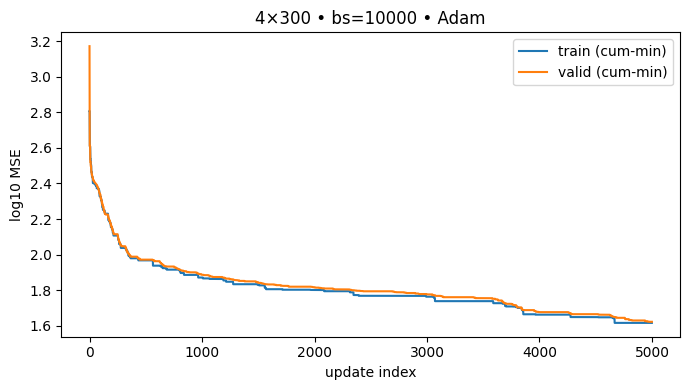


Test results → MSE = 4.497e+01   R² = 0.9269


In [18]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=10000,
        n_updates=5000,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 20k

[update 1/250] train MSE=6.532e+02  val MSE=1.481e+03
[update 25/250] train MSE=2.778e+02  val MSE=2.748e+02
[update 50/250] train MSE=2.605e+02  val MSE=2.531e+02
[update 75/250] train MSE=2.301e+02  val MSE=2.347e+02
[update 100/250] train MSE=2.044e+02  val MSE=2.139e+02
[update 125/250] train MSE=1.799e+02  val MSE=1.789e+02
[update 150/250] train MSE=1.713e+02  val MSE=1.666e+02
[update 175/250] train MSE=1.566e+02  val MSE=1.595e+02
[update 200/250] train MSE=1.684e+02  val MSE=1.419e+02
[update 225/250] train MSE=1.274e+02  val MSE=1.334e+02
[update 250/250] train MSE=1.916e+02  val MSE=1.792e+02


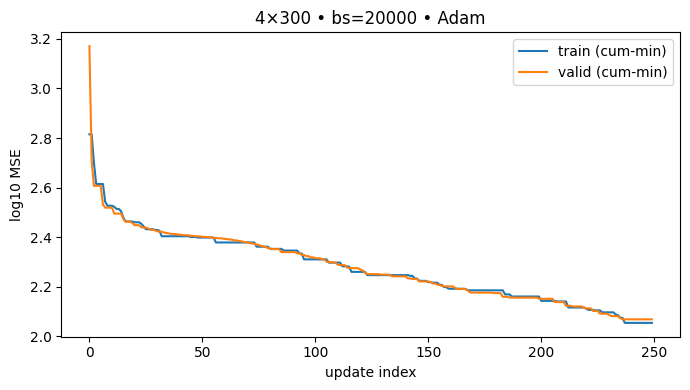


Test results → MSE = 1.631e+02   R² = 0.7351


In [7]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=20000,
        n_updates=250,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/2500] train MSE=6.532e+02  val MSE=1.481e+03
[update 250/2500] train MSE=1.916e+02  val MSE=1.792e+02
[update 500/2500] train MSE=1.239e+02  val MSE=1.200e+02
[update 750/2500] train MSE=8.341e+01  val MSE=8.240e+01
[update 1000/2500] train MSE=8.427e+01  val MSE=8.124e+01
[update 1250/2500] train MSE=7.336e+01  val MSE=7.273e+01
[update 1500/2500] train MSE=9.376e+01  val MSE=8.884e+01
[update 1750/2500] train MSE=9.140e+01  val MSE=7.350e+01
[update 2000/2500] train MSE=6.725e+01  val MSE=6.484e+01
[update 2250/2500] train MSE=8.105e+01  val MSE=8.554e+01
[update 2500/2500] train MSE=7.987e+01  val MSE=7.718e+01


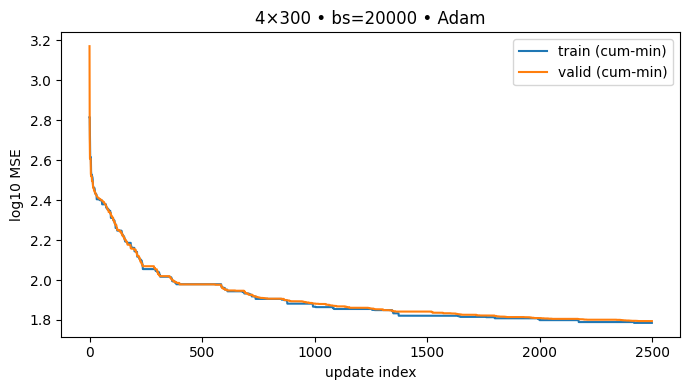


Test results → MSE = 7.371e+01   R² = 0.8802


In [19]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=20000,
        n_updates=2500,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 50k

[update 1/100] train MSE=6.522e+02  val MSE=1.478e+03
[update 10/100] train MSE=3.568e+02  val MSE=3.658e+02
[update 20/100] train MSE=2.987e+02  val MSE=2.866e+02
[update 30/100] train MSE=2.697e+02  val MSE=2.699e+02
[update 40/100] train MSE=2.570e+02  val MSE=2.590e+02
[update 50/100] train MSE=2.562e+02  val MSE=2.535e+02
[update 60/100] train MSE=2.529e+02  val MSE=2.486e+02
[update 70/100] train MSE=2.469e+02  val MSE=2.409e+02
[update 80/100] train MSE=2.310e+02  val MSE=2.283e+02
[update 90/100] train MSE=2.274e+02  val MSE=2.205e+02
[update 100/100] train MSE=2.124e+02  val MSE=2.039e+02


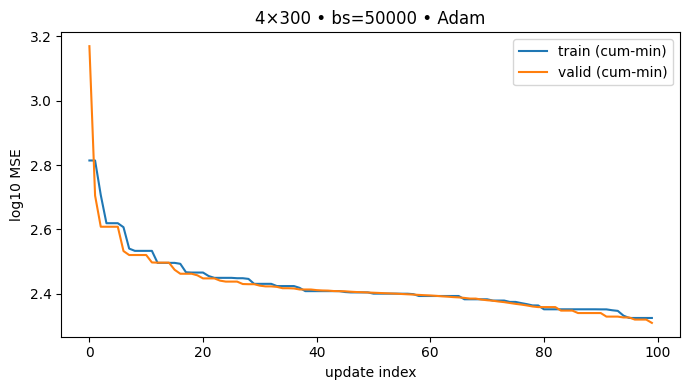


Test results → MSE = 2.289e+02   R² = 0.6281


In [8]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=50000,
        n_updates=100,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/1000] train MSE=6.522e+02  val MSE=1.478e+03
[update 100/1000] train MSE=2.124e+02  val MSE=2.039e+02
[update 200/1000] train MSE=1.322e+02  val MSE=1.514e+02
[update 300/1000] train MSE=1.151e+02  val MSE=1.123e+02
[update 400/1000] train MSE=1.000e+02  val MSE=9.671e+01
[update 500/1000] train MSE=9.284e+01  val MSE=9.113e+01
[update 600/1000] train MSE=9.811e+01  val MSE=1.045e+02
[update 700/1000] train MSE=1.299e+02  val MSE=1.242e+02
[update 800/1000] train MSE=9.051e+01  val MSE=8.632e+01
[update 900/1000] train MSE=8.472e+01  val MSE=8.155e+01
[update 1000/1000] train MSE=8.008e+01  val MSE=7.836e+01


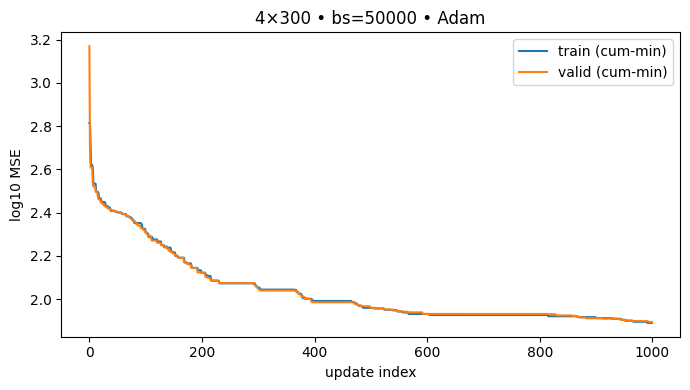


Test results → MSE = 7.461e+01   R² = 0.8788


In [20]:
run_experiment_updates_per_update(
        width=300,
        layers=4,
        batch_size=50000,
        n_updates=1000,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

# 5 x 2.5

## 5k

[update 1/1000] train MSE=1.456e+03  val MSE=3.668e+02
[update 100/1000] train MSE=2.124e+02  val MSE=2.007e+02
[update 200/1000] train MSE=1.705e+02  val MSE=1.474e+02
[update 300/1000] train MSE=1.159e+02  val MSE=1.032e+02
[update 400/1000] train MSE=1.173e+02  val MSE=1.378e+02
[update 500/1000] train MSE=1.497e+02  val MSE=1.391e+02
[update 600/1000] train MSE=8.612e+01  val MSE=9.517e+01
[update 700/1000] train MSE=9.018e+01  val MSE=1.036e+02
[update 800/1000] train MSE=9.865e+01  val MSE=8.240e+01
[update 900/1000] train MSE=7.255e+01  val MSE=7.994e+01
[update 1000/1000] train MSE=7.461e+01  val MSE=7.281e+01


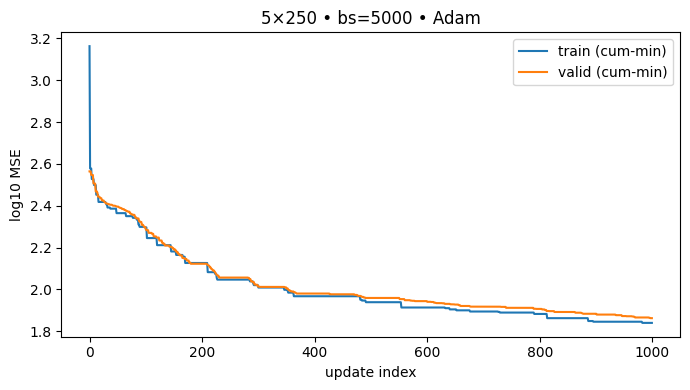


Test results → MSE = 6.990e+01   R² = 0.8864


In [9]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=5000,
        n_updates=1000,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/10000] train MSE=1.456e+03  val MSE=3.668e+02
[update 1000/10000] train MSE=7.461e+01  val MSE=7.281e+01
[update 2000/10000] train MSE=6.601e+01  val MSE=6.228e+01
[update 3000/10000] train MSE=6.431e+01  val MSE=5.324e+01
[update 4000/10000] train MSE=4.823e+01  val MSE=4.354e+01
[update 5000/10000] train MSE=3.837e+01  val MSE=3.812e+01
[update 6000/10000] train MSE=3.548e+01  val MSE=3.601e+01
[update 7000/10000] train MSE=3.607e+01  val MSE=3.404e+01
[update 8000/10000] train MSE=3.457e+01  val MSE=3.349e+01
[update 9000/10000] train MSE=3.480e+01  val MSE=3.223e+01
[update 10000/10000] train MSE=3.349e+01  val MSE=3.207e+01


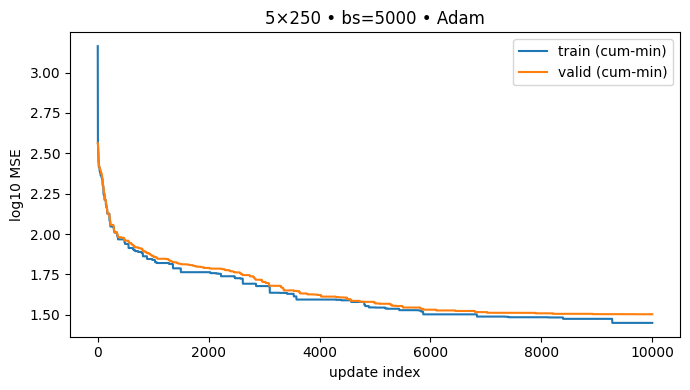


Test results → MSE = 3.305e+01   R² = 0.9463


In [31]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=5000,
        n_updates=10000,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/10000] train MSE=1.456e+03  val MSE=1.203e+03
[update 1000/10000] train MSE=9.061e+01  val MSE=9.409e+01
[update 2000/10000] train MSE=7.839e+01  val MSE=7.918e+01
[update 3000/10000] train MSE=7.596e+01  val MSE=7.271e+01
[update 4000/10000] train MSE=6.925e+01  val MSE=7.031e+01
[update 5000/10000] train MSE=6.672e+01  val MSE=6.843e+01
[update 6000/10000] train MSE=6.687e+01  val MSE=6.909e+01
[update 7000/10000] train MSE=7.167e+01  val MSE=6.893e+01
[update 8000/10000] train MSE=7.220e+01  val MSE=6.553e+01
[update 9000/10000] train MSE=6.271e+01  val MSE=6.373e+01
[update 10000/10000] train MSE=6.261e+01  val MSE=6.330e+01


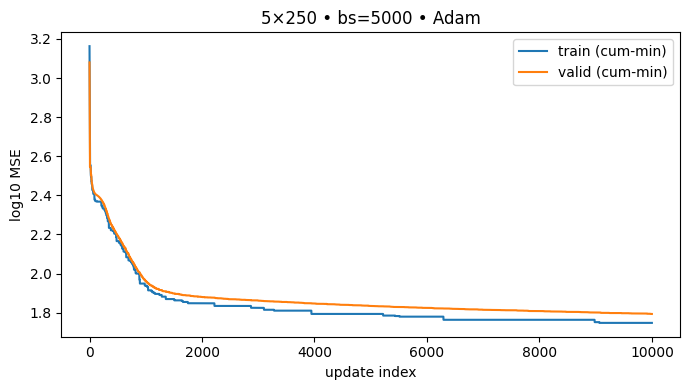


Test results → MSE = 6.107e+01   R² = 0.9008


In [30]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=5000,
        n_updates=10000,
        lr=1e-4,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/1000] train MSE=1.456e+03  val MSE=2.502e+05
[update 100/1000] train MSE=2.577e+02  val MSE=3.636e+02
[update 200/1000] train MSE=4.411e+02  val MSE=6.338e+02
[update 300/1000] train MSE=2.162e+02  val MSE=3.037e+02
[update 400/1000] train MSE=1.260e+02  val MSE=1.327e+02
[update 500/1000] train MSE=1.275e+02  val MSE=9.676e+01
[update 600/1000] train MSE=8.958e+01  val MSE=9.887e+01
[update 700/1000] train MSE=2.598e+02  val MSE=1.813e+02
[update 800/1000] train MSE=8.534e+01  val MSE=8.331e+01
[update 900/1000] train MSE=7.889e+01  val MSE=9.907e+01
[update 1000/1000] train MSE=1.294e+02  val MSE=1.505e+02


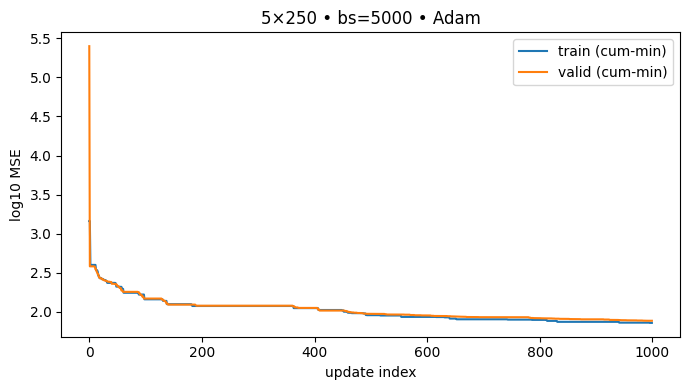


Test results → MSE = 1.695e+02   R² = 0.7246


In [29]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=5000,
        n_updates=1000,
        lr=1e-2,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 10k

[update 1/500] train MSE=1.477e+03  val MSE=3.665e+02
[update 50/500] train MSE=2.539e+02  val MSE=2.472e+02
[update 100/500] train MSE=2.710e+02  val MSE=1.975e+02
[update 150/500] train MSE=1.488e+02  val MSE=1.490e+02
[update 200/500] train MSE=1.397e+02  val MSE=1.408e+02
[update 250/500] train MSE=2.406e+02  val MSE=2.345e+02
[update 300/500] train MSE=1.496e+02  val MSE=1.495e+02
[update 350/500] train MSE=1.063e+02  val MSE=1.088e+02
[update 400/500] train MSE=1.136e+02  val MSE=1.095e+02
[update 450/500] train MSE=9.269e+01  val MSE=9.417e+01
[update 500/500] train MSE=2.135e+02  val MSE=1.803e+02


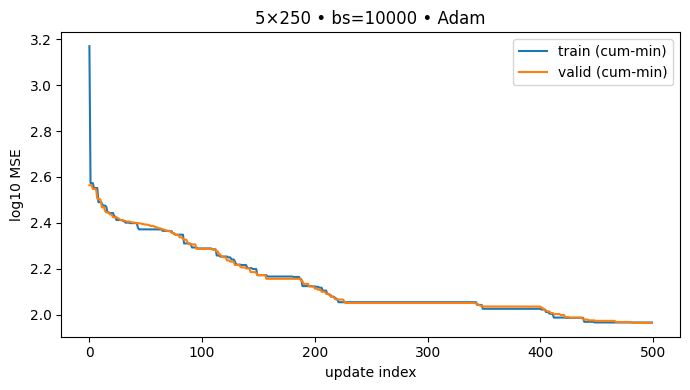


Test results → MSE = 2.153e+02   R² = 0.6502


In [10]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=10000,
        n_updates=500,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 20k

[update 1/250] train MSE=1.471e+03  val MSE=3.666e+02
[update 25/250] train MSE=2.737e+02  val MSE=2.652e+02
[update 50/250] train MSE=2.563e+02  val MSE=2.458e+02
[update 75/250] train MSE=2.163e+02  val MSE=2.159e+02
[update 100/250] train MSE=2.158e+02  val MSE=1.865e+02
[update 125/250] train MSE=1.684e+02  val MSE=1.675e+02
[update 150/250] train MSE=1.447e+02  val MSE=1.520e+02
[update 175/250] train MSE=1.309e+02  val MSE=1.321e+02
[update 200/250] train MSE=1.519e+02  val MSE=2.418e+02
[update 225/250] train MSE=1.463e+02  val MSE=1.542e+02
[update 250/250] train MSE=1.298e+02  val MSE=1.230e+02


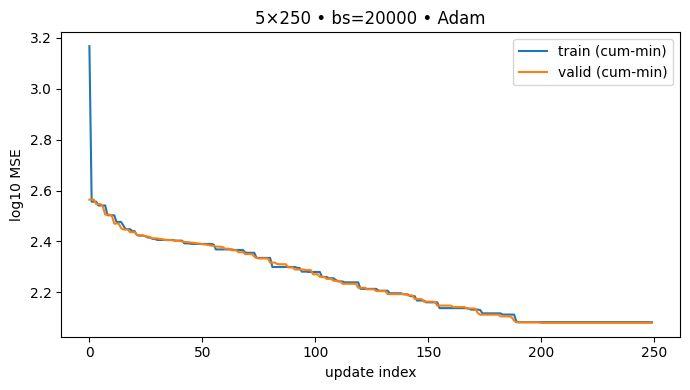


Test results → MSE = 1.223e+02   R² = 0.8012


In [11]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=20000,
        n_updates=250,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 50k

[update 1/100] train MSE=1.451e+03  val MSE=3.666e+02
[update 10/100] train MSE=3.389e+02  val MSE=3.363e+02
[update 20/100] train MSE=2.817e+02  val MSE=2.777e+02
[update 30/100] train MSE=2.588e+02  val MSE=2.595e+02
[update 40/100] train MSE=2.563e+02  val MSE=2.515e+02
[update 50/100] train MSE=2.508e+02  val MSE=2.462e+02
[update 60/100] train MSE=2.427e+02  val MSE=2.365e+02
[update 70/100] train MSE=2.618e+02  val MSE=2.833e+02
[update 80/100] train MSE=2.275e+02  val MSE=2.204e+02
[update 90/100] train MSE=2.117e+02  val MSE=2.013e+02
[update 100/100] train MSE=2.061e+02  val MSE=2.103e+02


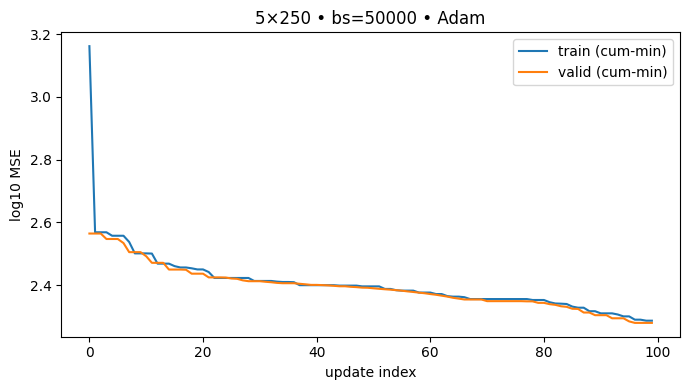


Test results → MSE = 2.124e+02   R² = 0.6549


In [12]:
run_experiment_updates_per_update(
        width=250,
        layers=5,
        batch_size=50000,
        n_updates=100,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

# 6x2

## 5k

[update 1/1000] train MSE=6.417e+02  val MSE=4.316e+02
[update 100/1000] train MSE=2.092e+02  val MSE=1.916e+02
[update 200/1000] train MSE=1.398e+02  val MSE=1.337e+02
[update 300/1000] train MSE=1.374e+02  val MSE=1.527e+02
[update 400/1000] train MSE=1.129e+02  val MSE=1.098e+02
[update 500/1000] train MSE=1.086e+02  val MSE=1.543e+02
[update 600/1000] train MSE=9.212e+01  val MSE=1.229e+02
[update 700/1000] train MSE=1.105e+02  val MSE=1.012e+02
[update 800/1000] train MSE=1.154e+02  val MSE=9.329e+01
[update 900/1000] train MSE=8.536e+01  val MSE=8.462e+01
[update 1000/1000] train MSE=9.576e+01  val MSE=8.236e+01


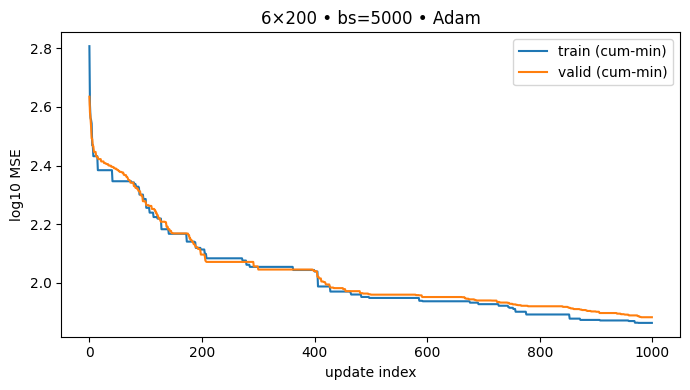


Test results → MSE = 7.887e+01   R² = 0.8719


In [13]:
run_experiment_updates_per_update(
        width=200,
        layers=6,
        batch_size=5000,
        n_updates=1000,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 10k

[update 1/500] train MSE=6.326e+02  val MSE=4.300e+02
[update 50/500] train MSE=2.407e+02  val MSE=2.394e+02
[update 100/500] train MSE=2.409e+02  val MSE=1.999e+02
[update 150/500] train MSE=1.632e+02  val MSE=1.701e+02
[update 200/500] train MSE=2.037e+02  val MSE=2.211e+02
[update 250/500] train MSE=1.617e+02  val MSE=1.472e+02
[update 300/500] train MSE=1.275e+02  val MSE=1.483e+02
[update 350/500] train MSE=2.032e+02  val MSE=1.860e+02
[update 400/500] train MSE=9.962e+01  val MSE=1.001e+02
[update 450/500] train MSE=1.927e+02  val MSE=1.682e+02
[update 500/500] train MSE=9.160e+01  val MSE=9.352e+01


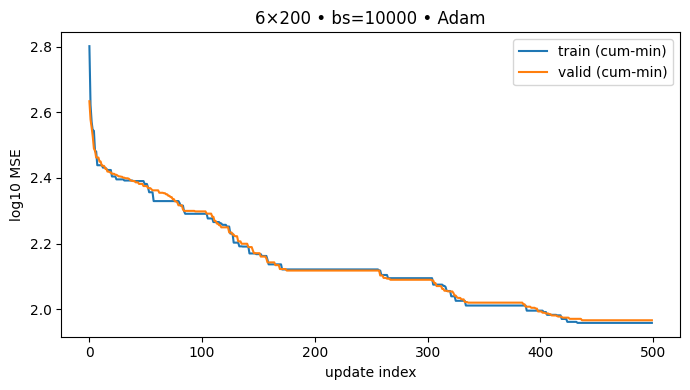


Test results → MSE = 8.762e+01   R² = 0.8576


In [14]:
run_experiment_updates_per_update(
        width=200,
        layers=6,
        batch_size=10000,
        n_updates=500,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 20k

[update 1/250] train MSE=6.375e+02  val MSE=4.314e+02
[update 25/250] train MSE=2.576e+02  val MSE=2.540e+02
[update 50/250] train MSE=2.452e+02  val MSE=2.354e+02
[update 75/250] train MSE=2.457e+02  val MSE=2.252e+02
[update 100/250] train MSE=1.927e+02  val MSE=1.859e+02
[update 125/250] train MSE=2.254e+02  val MSE=2.065e+02
[update 150/250] train MSE=1.723e+02  val MSE=1.677e+02
[update 175/250] train MSE=2.832e+02  val MSE=3.211e+02
[update 200/250] train MSE=1.550e+02  val MSE=1.645e+02
[update 225/250] train MSE=1.568e+02  val MSE=2.842e+02
[update 250/250] train MSE=1.323e+02  val MSE=1.490e+02


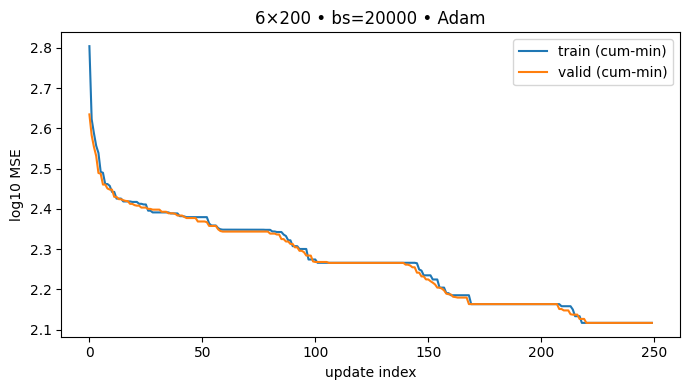


Test results → MSE = 1.401e+02   R² = 0.7724


In [15]:
run_experiment_updates_per_update(
        width=200,
        layers=6,
        batch_size=20000,
        n_updates=250,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

## 50k

[update 1/100] train MSE=6.556e+02  val MSE=4.319e+02
[update 10/100] train MSE=2.928e+02  val MSE=2.797e+02
[update 20/100] train MSE=2.697e+02  val MSE=2.647e+02
[update 30/100] train MSE=2.557e+02  val MSE=2.505e+02
[update 40/100] train MSE=2.440e+02  val MSE=2.435e+02
[update 50/100] train MSE=2.442e+02  val MSE=2.763e+02
[update 60/100] train MSE=2.419e+02  val MSE=2.326e+02
[update 70/100] train MSE=2.304e+02  val MSE=2.238e+02
[update 80/100] train MSE=2.130e+02  val MSE=2.114e+02
[update 90/100] train MSE=2.432e+02  val MSE=2.585e+02
[update 100/100] train MSE=2.035e+02  val MSE=2.165e+02


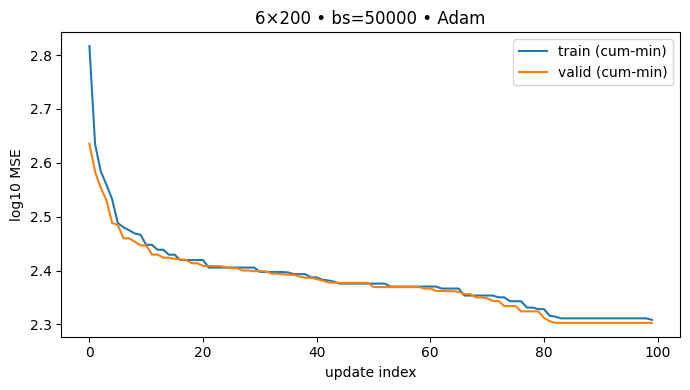


Test results → MSE = 2.253e+02   R² = 0.6340


In [16]:
run_experiment_updates_per_update(
        width=200,
        layers=6,
        batch_size=50000,
        n_updates=100,
        lr=LR,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

# Replicating Paper 1600x6

In [ ]:
run_experiment_updates_per_update(
        width=1600,
        layers=6,
        batch_size=50000,
        n_updates=100,
        lr=,
        optimizer_name="Adam",
        seed=42,
        save_model=False  
    )

[update 1/200000] train MSE=8.820e+02  val MSE=8.828e+04
[update 20000/200000] train MSE=3.141e+01  val MSE=3.183e+01
[update 40000/200000] train MSE=2.865e+01  val MSE=3.541e+01
[update 60000/200000] train MSE=2.074e+01  val MSE=3.984e+01
[update 80000/200000] train MSE=1.955e+01  val MSE=4.363e+01


KeyboardInterrupt: 